# Sentimental Analysis Amazon Review (Music Instrument) by Group 3

In [1]:
import json
import nltk # for porter stemmer
import numpy as np
import pandas as pd
import re
import sklearn as skl
import string
import time

## I) Preprocessing data

### Text processing methods

In [2]:
# function to remove stop word and punctuations 
def rm_stopwords_punctuation(text):
    text = text.lower()
    with open("stopwords.json") as stopword_file:
        stopwords = json.load(stopword_file)
        for word in stopwords:
            if word in text:
                # replace only complete words ('\b' is a word boundary)
                text = re.sub(r"\b{}\b".format(word), "", text)
    # remove punctuation
    for char in string.punctuation:
        text = text.replace(char, "")
    text = re.sub(r"\b[a-z]\b", "", text)
    # remove whitespace
    for char in string.punctuation:
        text = text.replace(char, "")
    text = ' '.join(text.split(None))
    return text

In [3]:
# funtion to remove stemmer using porterstem
def stem(text):
    stemmer = nltk.stem.porter.PorterStemmer()
    # stem each word individually, and concatenate
    text = ' '.join([stemmer.stem(word) for word in text.split(None)])
    return text

In [4]:
# a method to apply 2 functions described above stopwords, punctuation and stemmer
def process_text(text):
    text = rm_stopwords_punctuation(text)
    text = stem(text)
    return text

### Import and process music dataset

In [5]:
# Read the train and test data
music_test = pd.read_json("data/reviews_Musical_Instruments_5.json", lines=True)

In [6]:
# Drop the unwanted columns in our data

# Drop Justifications:
#   asin: Because the data set we used for this project contains information on multiple products, the assignment ID is not helpful
#   helpful: Displays how helpful other viewers of the product page found the specific review (i.e. reviews of the review)
#   reviewTime: Time of the review isn't needed for our purposes
#   reviewerID: Unique ID for reviewers. Irrelevant for sentiment analysis
#   reviewerName: Reviwer name. Irrelevant for sentiment analysis
#   summary: Bold text prefacing the review. We preferred to look at the contents of the reviews themselves
#   unixReviewTime: Unix version of review time isn't needed for our purposes

music_test = music_test.drop(['asin', 'helpful', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime'], axis=1)

### Classify the data based on review rating

In [7]:
# create a column called "good" if the overall rating is 5 and assign boolean value
# test2 = music_test.assign(good = lambda g: g.overall >= 5)
# create a column called "good" if the overall rating is 4 or above and assign boolean value
test2 = music_test.assign(good = lambda g: g.overall >= 5)
# create a binary classfication 1 for all data that are good and 0 for that are not
music_test = music_test.assign(good = test2['good'].apply(lambda g: 1 if g else 0))


# display the first 10 data
music_test.head(10)

,overall,reviewText,good
0,5,"Not much to write about here, but it does exac...",1
1,5,The product does exactly as it should and is q...,1
2,5,The primary job of this device is to block the...,1
3,5,Nice windscreen protects my MXL mic and preven...,1
4,5,This pop filter is great. It looks and perform...,1
5,5,So good that I bought another one. Love the h...,1
6,5,"I have used monster cables for years, and with...",1
7,3,I now use this cable to run from the output of...,0
8,5,Perfect for my Epiphone Sheraton II. Monster ...,1
9,5,Monster makes the best cables and a lifetime w...,1


In [8]:
# copy train data to apply process_text method describe above
music_test_noP = music_test.copy()
music_test_P = music_test.copy()
music_test_P['reviewText'] = music_test['reviewText'].apply(lambda t: process_text(t))

# display the first 10 data
music_test_P.head(10)

,overall,reviewText,good
0,5,much write exactli suppos filter pop sound now...,1
1,5,product exactli quit afford realiz doubl scree...,1
2,5,primari job devic block breath otherwis produc...,1
3,5,nice windscreen protect mxl mic prevent pop th...,1
4,5,pop filter great look perform like studio filt...,1
5,5,good bought anoth one love heavi cord gold con...,1
6,5,use monster cabl year good reason lifetim warr...,1
7,3,now use cabl run output pedal chain input fend...,0
8,5,perfect epiphon sheraton ii monster cabl well ...,1
9,5,monster make best cabl lifetim warranti doesnt...,1


### Import and process video game dataset

In [11]:
start_time = time.time()

# read the video game file
vg_train = pd.read_json("data/reviews_Video_Games_5.json", lines=True)


# drop unused columns
vg_train = vg_train.drop(['asin', 'helpful', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime'], axis=1)

# show how long it takes in seconds to import + drop for this much data 
elapsed_time = time.time() - start_time
print("vg import:", elapsed_time, "sec")

vg_train.describe()

vg import: 15.649417161941528 sec


,overall
count,231780.000000
mean,4.086397
std,1.202330
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [12]:
start_time = time.time()

# repeat the same process, create classficiation 
# vg_train2 = vg_train.assign(good = lambda g: g.overall >= 5)
vg_train2 = vg_train.assign(good = lambda g: g.overall >= 4)
vg_train = vg_train.assign(good = vg_train2['good'].apply(lambda g: 1 if g else 0))
vg_train_noP = vg_train.copy()

# This is too much data to process
# vg_train_P = vg_train.copy()
# vg_train_P['reviewText'] = vg_train['reviewText'].apply(lambda t: process_text(t))

vg_train_P_sample = vg_train.sample(frac=0.1)
vg_train_P_sample['reviewText'] = vg_train_P_sample['reviewText'].apply(lambda t: process_text(t))

elapsed_time = time.time() - start_time
print("vg process:", elapsed_time, "sec")

vg_train_P_sample.describe()

vg process: 146.84517121315002 sec


,overall,good
count,23178.000000,23178.000000
mean,4.088230,0.754509
std,1.200462,0.430387
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## II) Export and Import processed data for faster running time

###  Export processed data

In [13]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_json.html
vg_train_P_sample.to_json("vg_reviews_text_processed_10%.json")
print("saved ", "vg_reviews_text_processed_10%.json")
vg_train_noP.to_json("vg_reviews_original_text.json")
print("saved ", "vg_reviews_original_text.json")
music_test_P.to_json("music_reviews_text_processed.json")
print("saved ", "music_reviews_text_processed.json")
music_test_noP.to_json("music_reviews_original_text.json")
print("saved ", "music_reviews_original_text.json")

saved  vg_reviews_text_processed_10%.json
saved  vg_reviews_original_text.json
saved  music_reviews_text_processed.json
saved  music_reviews_original_text.json


### Import preprocessed data

This lets us skip every line of code above this point

In [14]:
vg_train = pd.read_json("vg_reviews_text_processed_10%.json")
music_test = pd.read_json("music_reviews_text_processed.json")

vg_train.describe()

,good,overall
count,23178.000000,23178.000000
mean,0.754509,4.088230
std,0.430387,1.200462
min,0.000000,1.000000
25%,1.000000,4.000000
50%,1.000000,5.000000
75%,1.000000,5.000000
max,1.000000,5.000000


## III) Prediction Algorithms: Logistic Regression

### A) Train logistic regression on video games

In [15]:
y_vg_train = vg_train["good"]

cv_vg = skl.feature_extraction.text.CountVectorizer()
vg_counts = cv_vg.fit_transform(vg_train['reviewText'].values)

In [16]:
vg_counts.shape

(23178, 76080)

In [17]:
# These aren't used, but they could be.
tf_transformer = skl.feature_extraction.text.TfidfTransformer(use_idf=False).fit(vg_counts)
vg_train_tf = tf_transformer.transform(vg_counts)
tfidf_transformer = skl.feature_extraction.text.TfidfTransformer()
vg_train_tfidf = tfidf_transformer.fit_transform(vg_counts)

In [18]:
sklmodel = skl.linear_model.LogisticRegression()

sklmodel = sklmodel.fit(vg_counts, y_vg_train)
# sklmodel = sklmodel.fit(vg_train_tfidf, y_vg_train)

### Test video game dataset against itself (full size)
### Score

In [19]:
sklmodel.score(vg_counts, y_vg_train)
# sklmodel.score(vg_train_tfidf, y_vg_train)

0.96147208559841224

In [20]:
# compare against random guessing
y_vg_train.mean()

0.7545085857278454

### Re-train and Test video game dataset against itself (partial) using logistic regression

### We split the video game dataset into two randomized subsets, 75% for training and 25% for testing.

In [21]:
cv_vg = skl.feature_extraction.text.CountVectorizer()
vg_counts = cv_vg.fit_transform(vg_train['reviewText'].values)

In [22]:
from sklearn.model_selection import train_test_split

vg_X = vg_counts
vg_y = vg_train['good']

# random_state=0 to use the same RNG seed
vg_X_train, vg_X_test, vg_y_train, vg_y_test = train_test_split(vg_X, vg_y, random_state=0)

In [23]:
sklmodel = skl.linear_model.LogisticRegression()

sklmodel = sklmodel.fit(vg_X_train, vg_y_train)

### Score

In [24]:
sklmodel.score(vg_X_test, vg_y_test)

0.82001725625539257

In [25]:
predictions = sklmodel.predict(vg_X_test)
vg_test_lr_df = pd.DataFrame({'good': vg_y_test.values, 'guess_good': predictions})

### B) Test logistic regression on music dataset

In [26]:
# vg_y.mean()

In [27]:
y_music_test = music_test["good"]

vg_vocab = cv_vg.get_feature_names()
cv_music = skl.feature_extraction.text.CountVectorizer(vocabulary=vg_vocab)
music_counts = cv_music.fit_transform(music_test['reviewText'].values)

# This isn't needed, because the words in the music review vocabulary that *aren't* in
# the video game vocabulary haven't been trained against anyways.
# music_vocab = cv_music.get_feature_names()
# len(cv_music.get_feature_names())
# len(music_vocab + list(set(vg_vocab) - set(music_vocab)))

In [28]:
predictions = sklmodel.predict(music_counts)
predictions

array([1, 1, 1, ..., 1, 1, 1])

### Score 

In [29]:
sum = 0
wrong_on_good = 0
wrong_on_bad  = 0
for i in range(0, len(predictions)):
    if predictions[i] != y_music_test[i]:
        sum += 1
        if y_music_test[i] == 1:
            wrong_on_good += 1
        else:
            wrong_on_bad += 1

print("score:", 1 - sum/len(predictions), "\n")
print("misses of good scores:", wrong_on_good)
print("misses of bad scores: ", wrong_on_bad)

score: 0.6401910145210019 

misses of good scores: 658
misses of bad scores:  3034


In [30]:
music_tf_transformer = skl.feature_extraction.text.TfidfTransformer(use_idf=False).fit(music_counts)
music_train_tf = music_tf_transformer.transform(music_counts)
# music_tfidf_transformer = skl.feature_extraction.text.TfidfTransformer()
# music_train_tfidf = music_tfidf_transformer.fit_transform(music_counts)

### Predict using transformed music data

In [31]:
predictions = sklmodel.predict(music_train_tf)
predictions

array([1, 1, 1, ..., 1, 1, 1])

### Score

In [32]:
sum = 0
wrong_on_good = 0
wrong_on_bad  = 0
for i in range(0, len(predictions)):
    if predictions[i] != y_music_test[i]:
        sum += 1
        if y_music_test[i] == 1:
            wrong_on_good += 1
        else:
            wrong_on_bad += 1

print("score:", 1 - sum/len(predictions), "\n")
print("misses of good scores:", wrong_on_good)
print("misses of bad scores: ", wrong_on_bad)

music_predicted_lr_df = music_test_P.copy()
music_predicted_lr_df['guess_good'] = predictions

music_predicted_lr_df.head()

score: 0.6762498781795147 

misses of good scores: 0
misses of bad scores:  3322


,overall,reviewText,good,guess_good
0,5,much write exactli suppos filter pop sound now...,1,1
1,5,product exactli quit afford realiz doubl scree...,1,1
2,5,primari job devic block breath otherwis produc...,1,1
3,5,nice windscreen protect mxl mic prevent pop th...,1,1
4,5,pop filter great look perform like studio filt...,1,1


## IV) Prediction Algorithms: Naive Bayes

### A) Train naive bayes on full video game dataset

In [33]:
cv_vg = skl.feature_extraction.text.CountVectorizer()
vg_counts = cv_vg.fit_transform(vg_train['reviewText'].values)
y_vg_train = vg_train["overall"]

print(vg_counts.shape)

(23178, 76080)


In [34]:
from sklearn.naive_bayes import MultinomialNB

NB_clf = MultinomialNB()
NB_clf.fit(vg_counts, y_vg_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Test full dataset against itself

In [35]:
NB_clf.score(vg_counts, y_vg_train)

0.69725601863836395

### Score

In [36]:
# This is what `score(vg_counts, y_vg_train)` basically is.

predictions = NB_clf.predict(vg_counts)
predictions

sum = 0
for i in range(0, len(predictions)):
    if predictions[i] != y_vg_train.values[i]:
        sum += 1

print("Score: ", 1 - sum/len(predictions))

Score:  0.697256018638364


### Re-train and test  video games data against itself (partial) using Naive Bayes

### We can split the video game dataset into two randomized subsets, 75% for training and 25% for testing.

In [37]:
cv_vg = skl.feature_extraction.text.CountVectorizer()
vg_counts = cv_vg.fit_transform(vg_train['reviewText'].values)

In [38]:
from sklearn.model_selection import train_test_split

vg_X = vg_counts
vg_y = vg_train['overall']

# random_state=0 to use the same RNG seed
vg_X_train, vg_X_test, vg_y_train, vg_y_test = train_test_split(vg_X, vg_y, random_state=0)

### Score with a "normal" `alpha=1`

In [39]:
NB_clf = MultinomialNB(alpha=1)
NB_clf.fit(vg_X_train, vg_y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

### Train's Score

In [40]:
NB_clf.score(vg_X_train, vg_y_train)

0.68325375366737617

### Test's Score

In [41]:
NB_clf.score(vg_X_test, vg_y_test)

0.5404659188955997

#### If we set `alpha=0.1`, the score of testing the dataset against *itself* improves dramatically, but scoring against the test dataset remains unchanged.

In [42]:
NB_clf = MultinomialNB(alpha=0.1)
NB_clf.fit(vg_X_train, vg_y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

### Train's Score

In [43]:
NB_clf.score(vg_X_train, vg_y_train)

0.84841511821894955

### Test's Score

In [44]:
NB_clf.score(vg_X_test, vg_y_test)

0.51233822260569462

Setting alpha = 1

In [45]:
# alpha=1 is what we're going to be working with

NB_clf = MultinomialNB(alpha=1)
NB_clf.fit(vg_X_train, vg_y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [46]:
predictions = NB_clf.predict(vg_X_test)

sum = 0
wrong_on_good = 0
wrong_on_bad  = 0
for i in range(0, len(predictions)):
    if predictions[i] != vg_y_test.values[i]:
        sum += 1
        if y_music_test[i] == 1:
            wrong_on_good += 1
        else:
            wrong_on_bad += 1

print("score:", (1 - sum/len(predictions)), "\n")
print("misses of good scores:", wrong_on_good)
print("misses of bad scores: ", wrong_on_bad)

vg_test_nb_df = pd.DataFrame({'overall': vg_y_test.values, 'guess_overall': predictions})

score: 0.5404659188955996 

misses of good scores: 1841
misses of bad scores:  822


## B) Test Naive Bayes on music dataset

In [47]:
y_music_test = music_test_P["overall"]

music_vocab = cv_vg.get_feature_names()
cv_music = skl.feature_extraction.text.CountVectorizer(vocabulary=vg_vocab)
music_counts = cv_music.fit_transform(music_test_P['reviewText'].values)

In [48]:
predictions = NB_clf.predict(music_counts)
predictions

array([5, 5, 5, ..., 5, 5, 4])

### Score

In [49]:
sum = 0
wrong_on_good = 0
wrong_on_bad  = 0
for i in range(0, len(predictions)):
    if predictions[i] != y_music_test[i]:
        sum += 1
        if y_music_test[i] == 1:
            wrong_on_good += 1
        else:
            wrong_on_bad += 1

print("score:", (1 - sum/len(predictions)), "\n")
print("misses of good scores:", wrong_on_good)
print("misses of bad scores: ", wrong_on_bad)

music_predicted_nb_df = music_test_P.copy()
music_predicted_nb_df['guess_overall'] = predictions

music_predicted_nb_df.head()

score: 0.6575382516323944 

misses of good scores: 215
misses of bad scores:  3299


,overall,reviewText,good,guess_overall
0,5,much write exactli suppos filter pop sound now...,1,5
1,5,product exactli quit afford realiz doubl scree...,1,5
2,5,primari job devic block breath otherwis produc...,1,5
3,5,nice windscreen protect mxl mic prevent pop th...,1,4
4,5,pop filter great look perform like studio filt...,1,4


In [50]:
NB_clf.score(music_counts, y_music_test)

0.65753825163239454

#### If we set `alpha=0.1`, the score of testing the dataset against *itself* improves dramatically, but scoring against the test dataset remains unchanged.

In [51]:
NB_clf = MultinomialNB(alpha=0.1)
NB_clf.fit(music_counts, y_music_test )

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

### Train's Score

In [52]:
NB_clf.score(music_counts, y_music_test )

0.79621869213526941

### Test's Score

In [53]:
NB_clf.score(music_counts, y_music_test)

0.79621869213526941

# V) Data Visualizations

In [54]:
import matplotlib.pyplot as plt

## A) Logistic Regression visualizations over video game data

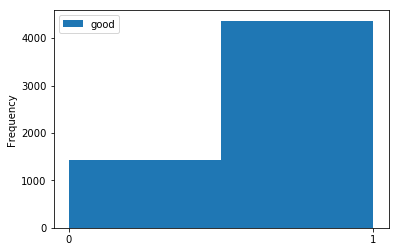

In [55]:
ax = vg_test_lr_df.plot.hist(y='good', bins=2)
ax.set_xticks([0, 1])

plt.show()

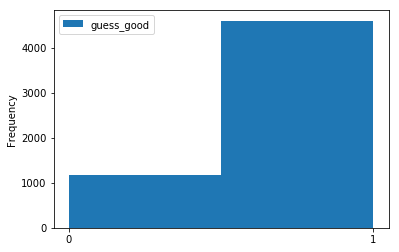

In [56]:
ax = vg_test_lr_df.plot.hist(y='guess_good', bins=2)
ax.set_xticks([0, 1])

plt.show()

## Logistic Regression visualizations over music data

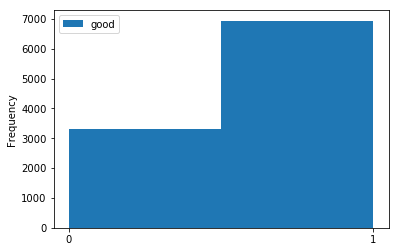

In [57]:
ax = music_predicted_lr_df.plot.hist(y='good', bins=2)
ax.set_xticks([0, 1])

plt.show()

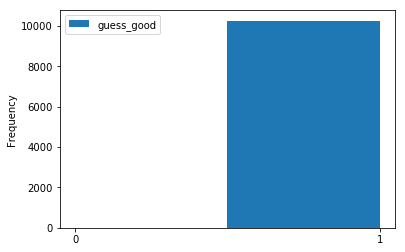

In [58]:
ax = music_predicted_lr_df.plot.hist(y='guess_good', bins=2)
ax.set_xticks([0, 1])

plt.show()

## B) Naive Bayes visualizations over video game data

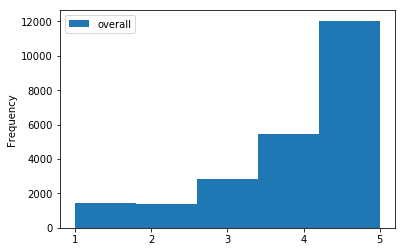

In [59]:
ax = vg_train.plot.hist(y='overall', bins=5)
ax.set_xticks([1,2,3,4,5])

plt.show()

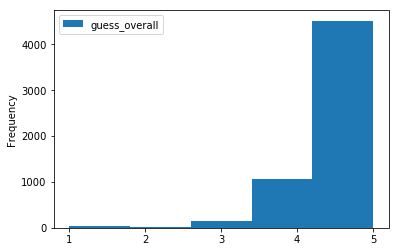

In [60]:
ax = vg_test_nb_df.plot.hist(y='guess_overall', bins=5)
ax.set_xticks([1,2,3,4,5])

plt.show()

## Naive Bayes visualizations over music data

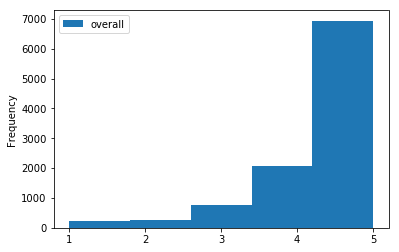

In [61]:
ax = music_test_P.plot.hist(y='overall', bins=5)
ax.set_xticks([1,2,3,4,5])

plt.show()

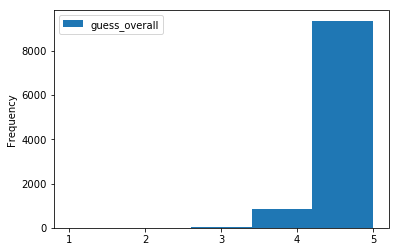

In [62]:
ax = music_predicted_nb_df.plot.hist(y='guess_overall', bins=5)
ax.set_xticks([1,2,3,4,5])

plt.show()